100%|██████████| 50/50 [00:18<00:00,  2.78it/s]


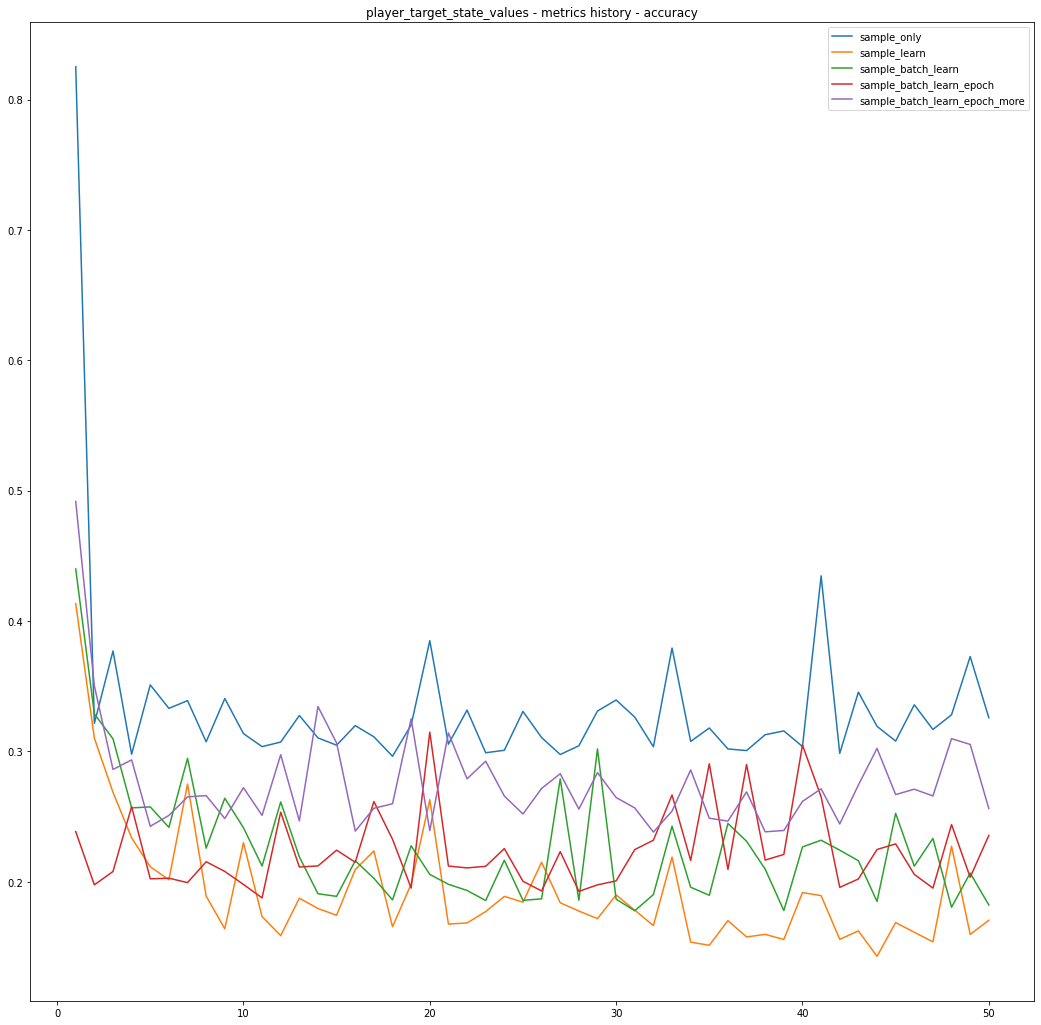

In [1]:
# TASK:
# - for linear approximation,
#   check (sample_only, sample_learn, sample_batch_learn,
#   sample_batch_learn_epoch) ~ convergence
#
# PROCESS;
# - sample EPISODES experiences with different control config
#   (sample_only, sample_learn_with_td, sample_batch_learn_with_td,
#   sample_batch_learn_epoch)
# - replay experience to fit with value approximator
#
# RESULTS:
# - sample_only: initial accuracy=0.8, after replay final_accuracy <0.2
# - sample_learn: initial accuracy=0,4, after replay final_accuracy <0.2
# - sample_batch_learn: initial accuracy~0.25, final accuracy < 0.2
# - sample_batch_learn_epoch: initial accuracy~0.22, final accuracy ~ 0.22
# - sample_batch_learn_epoch_more: initial accuracy~0.4, final accuracy~0.4
#
# INTERPRETATION:
# - control(learning during sampling) doesn't seem to help the final accuracy
# - especially when exploration_rate is kept at 0.5
# - using batch_method for control during sampling introduces more bias to
#   sampling, as it generate more samples from a sub-optimal policy as compared
#   to a random initial policy
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import trange
from random import shuffle

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS, STATE_LABELS, PLAYER_STATES
from src.easy_21.feature_function import full_binary_feature

#
# hyperparameters and agent config
#

EPISODES = int(1e4)

EPOCH = 50

MINI_BATCH_SIZE = 20
MINI_EPOCH = 5

PLAYER = ModelFreeAgent(
    "player",
    ACTIONS,
    STATE_LABELS,
    PLAYER_STATES,
    state_action_parser=full_binary_feature,
)
PLAYER.load_optimal_state_values()

PLAYER.target_state_value_store.metrics.register(
    "accuracy",
    PLAYER.target_state_value_store_accuracy_to_optimal,
)

#
# process
#


# sample only
PLAYER.action_value_store.reset()

experiences = [
    playout(player_policy=PLAYER.e_greedy_policy)[0] for _ in trange(EPISODES)
]

for _ in trange(EPOCH):
    PLAYER.target_state_value_store.metrics.record("accuracy")

    shuffle(experiences)
    PLAYER.forward_td_lambda_learning_offline_batch(experiences)


PLAYER.target_state_value_store.metrics.stack("accuracy")

# sample_learn
PLAYER.action_value_store.reset()

experiences = [
    playout(
        player_policy=PLAYER.e_greedy_policy,
        player_offline_learning=PLAYER.forward_td_lambda_learning_offline,
    )[0]
    for _ in trange(EPISODES)
]

for _ in trange(EPOCH):
    PLAYER.target_state_value_store.metrics.record("accuracy")

    shuffle(experiences)
    PLAYER.forward_td_lambda_learning_offline_batch(experiences)

PLAYER.target_state_value_store.metrics.stack("accuracy")

# sample_batch_learn
PLAYER.action_value_store.reset()
experiences = []

for i in trange(EPISODES):
    episode, _ = playout(player_policy=PLAYER.e_greedy_policy)
    experiences.append(episode)
    if i % MINI_BATCH_SIZE == 0:
        PLAYER.forward_td_lambda_learning_offline_batch(experiences[-MINI_BATCH_SIZE:])

for _ in trange(EPOCH):
    PLAYER.target_state_value_store.metrics.record("accuracy")

    shuffle(experiences)
    PLAYER.forward_td_lambda_learning_offline_batch(experiences)


PLAYER.target_state_value_store.metrics.stack("accuracy")

# sample_batch_learn_epoch
PLAYER.action_value_store.reset()
experiences = []

for i in trange(EPISODES):
    episode, _ = playout(player_policy=PLAYER.e_greedy_policy)
    experiences.append(episode)

    if i % MINI_BATCH_SIZE == 0:
        for _ in range(MINI_EPOCH):
            PLAYER.forward_td_lambda_learning_offline_batch(
                experiences[-MINI_BATCH_SIZE:]
            )

for _ in trange(EPOCH):
    PLAYER.target_state_value_store.metrics.record("accuracy")

    shuffle(experiences)
    PLAYER.forward_td_lambda_learning_offline_batch(experiences)


PLAYER.target_state_value_store.metrics.stack("accuracy")

# sample_batch_learn_epoch_more
PLAYER.action_value_store.reset()
experiences = []

for i in trange(EPISODES):
    episode, _ = playout(player_policy=PLAYER.e_greedy_policy)
    experiences.append(episode)

    if i % MINI_BATCH_SIZE == 0:
        for _ in range(5 * MINI_EPOCH):
            PLAYER.forward_td_lambda_learning_offline_batch(
                experiences[-MINI_BATCH_SIZE:]
            )

for _ in trange(EPOCH):
    PLAYER.target_state_value_store.metrics.record("accuracy")

    shuffle(experiences)
    PLAYER.forward_td_lambda_learning_offline_batch(experiences)


PLAYER.target_state_value_store.metrics.stack("accuracy")

# plot result
labels = [
    "sample_only",
    "sample_learn",
    "sample_batch_learn",
    "sample_batch_learn_epoch",
    "sample_batch_learn_epoch_more",
]
PLAYER.target_state_value_store.metrics.plot_history_stack(
    "accuracy",
    labels=labels,
)
